In [7]:
#1. Importer les bibliothèques
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from tensorflow import keras
from tensorflow.keras import layers

In [8]:
#2. Exemple de dataset (maison à Dakar)
data = {
    "quartier": ["Plateau","Almadies","Parcelles","Yoff","Pikine","Guediawaye","Mamelles","Liberté 6","Ouakam","Medina"],
    "surface": [120, 250, 90, 110, 75, 80, 140, 100, 130, 85],#en m2
    "chambres": [3, 5, 2, 3, 2, 2, 4, 3, 3, 2],
    "prix": [150, 350, 120, 180, 60, 70, 220, 160, 200, 110]  # en millions FCFA
}

df = pd.DataFrame(data)
df

,quartier,surface,chambres,prix
0,Plateau,120,3,150
1,Almadies,250,5,350
2,Parcelles,90,2,120
3,Yoff,110,3,180
4,Pikine,75,2,60
5,Guediawaye,80,2,70
6,Mamelles,140,4,220
7,Liberté 6,100,3,160
8,Ouakam,130,3,200
9,Medina,85,2,110


In [9]:
#3. Traitement de données (Pandas)
#3.1. Encodage du quartier (variable catégorielle → numérique)
df["quartier_code"] = df["quartier"].astype("category").cat.codes
df.head()
#3.2. Sélection des features
X = df[["surface", "chambres", "quartier_code"]]
y = df["prix"]


[Text(0.5, 1.0, 'Prix des maisons à Dakar selon la surface'),
 Text(0.5, 0, 'Surface (m²)'),
 Text(0, 0.5, 'Prix (FCFA)')]

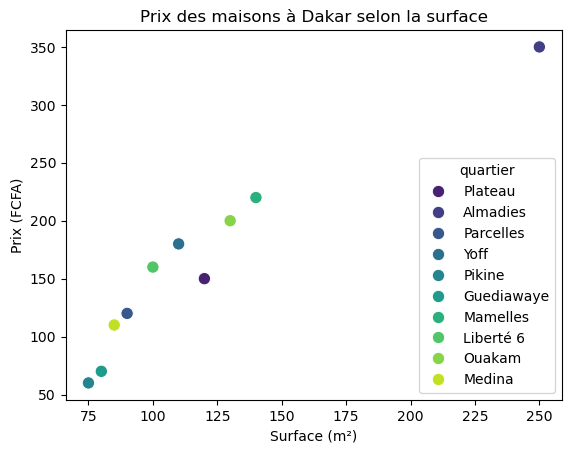

In [10]:
#4-Visualisation
# Relation Surface vs Prix
sns.scatterplot(
    data=df,
    x="surface",
    y="prix",
    hue="quartier",
    palette="viridis",
    s=80
).set(
    title="Prix des maisons à Dakar selon la surface",
    xlabel="Surface (m²)",
    ylabel="Prix (FCFA)"
)

[Text(0.5, 1.0, 'Distribution des prix par quartier'),
 Text(0.5, 0, 'Quartier'),
 Text(0, 0.5, 'Prix (FCFA)')]

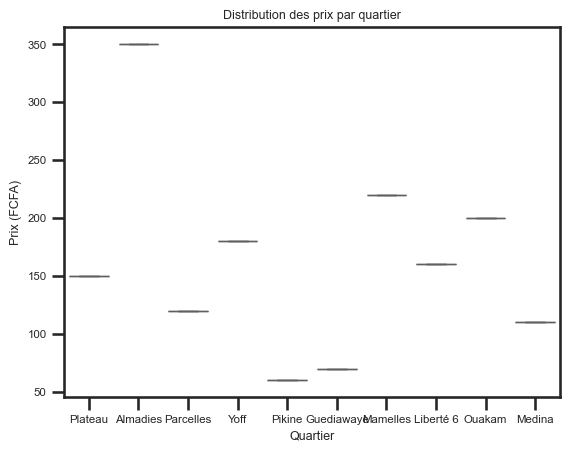

In [11]:
#Relation quartier vs prix
# Définir un contexte plus large pour agrandir le graphique
sns.set_theme(style="ticks")  # style général
sns.set_context("talk", font_scale=0.5)  # augmente taille des labels et titres
sns.boxplot(
    data=df,
    x="quartier",
    y="prix",
    hue="quartier",        # corrige le warning
    palette="Set3",
    dodge=False            # pour que chaque boîte reste à sa place
).set(
    title="Distribution des prix par quartier",
    xlabel="Quartier",
    ylabel="Prix (FCFA)"
)

[Text(0.5, 1.0, 'Heatmap des Corrélations entre Variables Numériques')]

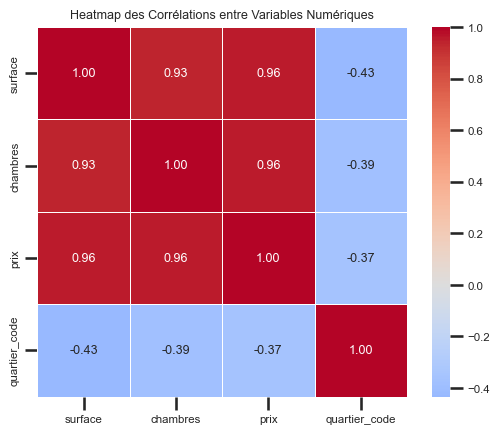

In [12]:
# Heatmap des corrélations
correlation_matrix = df.select_dtypes(include=['number']).corr()
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    square=True,
    fmt=".2f",
    linewidths=0.5
).set(title="Heatmap des Corrélations entre Variables Numériques")

In [13]:
#5. Préparation PyTorch
#Conversion en tenseurs :
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1,1)

In [14]:
#6. Construction d’un modèle simple avec PyTorch
#Modèle de régression linéaire :
model = nn.Sequential(
    nn.Linear(3, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [15]:
#7. Entraînement
epochs = 500
for epoch in range(epochs):
    y_pred = model(X_tensor)
    loss = loss_fn(y_pred, y_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss = {loss.item():.4f}")


Epoch 0, Loss = 27331.1914
Epoch 100, Loss = 642.1279
Epoch 200, Loss = 615.3851
Epoch 300, Loss = 600.0253
Epoch 400, Loss = 592.1964


In [16]:
#8. Prédiction Pytorch : Exemple
#Maison à Dakar :
#Surface = 150 m²
#Chambres = 4
#Quartier = "Yoff"
quartier_code = df[df["quartier"]=="Yoff"]["quartier_code"].values[0]

exemple = torch.tensor([[150, 4, quartier_code]], dtype=torch.float32)
prediction = model(exemple).item()
print(f"Prix prédit par pytorch : {prediction:.2f} millions FCFA")

Prix prédit par pytorch : 206.87 millions FCFA


In [17]:
#9. Modèle Keras
#9.1. Encodage du quartier (variable catégorielle → numérique)
df["quartier_code"] = df["quartier"].astype("category").cat.codes
df.head()
#9.2. Sélection des features
X = df[["surface", "chambres", "quartier_code"]]
y = df["prix"]
#Architecture choisie :
#Dense(16) + ReLU
#Dense(1)
# Modèle Keras
model_keras = keras.Sequential([
    keras.Input(shape=(3,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

model_keras.compile(optimizer='adam', loss='mse')

# Entraînement
history = model_keras.fit(X, y, epochs=500, verbose=0)

In [16]:
#10.Prédiction Keras : Exemple (le meme que precedemment)
quartier_code = df[df["quartier"]=="Yoff"]["quartier_code"].values[0]
exemple = np.array([[150, 4, quartier_code]])

prediction_keras = model_keras.predict(exemple)[0][0]
print("Prix prédit par Keras (millions FCFA) :", prediction_keras)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Prix prédit par Keras (millions FCFA) : 208.46599


In [18]:
#11. Comparaison quantitative (MSE, RMSE, R²)
# Conversion DataFrame en array numpy
X_array = X.values.astype(np.float32)  # float32 obligatoire pour PyTorch
# Conversion en tenseur PyTorch
X_tensor = torch.tensor(X_array, dtype=torch.float32)  # ✅ utiliser X_array

# Prédictions PyTorch
y_pred_pytorch = model(X_tensor).detach().numpy().reshape(-1)

# Prédictions Keras
y_pred_keras = model_keras.predict(X_array).reshape(-1)

from sklearn.metrics import mean_squared_error, r2_score
# Scores
def evaluate(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {name} ---")
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("R² :", r2)
    print()

evaluate(y, y_pred_keras, "Keras")
evaluate(y, y_pred_pytorch, "PyTorch")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
--- Keras ---
MSE: 691.6253662109375
RMSE: 26.29877119203362
R² : 0.8918659687042236

--- PyTorch ---
MSE: 587.0892944335938
RMSE: 24.22992559694713
R² : 0.9082099199295044



In [ ]:
"""Interprétation

MSE (Mean Squared Error) et RMSE (Root Mean Squared Error)
Plus ils sont faibles, meilleur est le modèle.
Ici, PyTorch a un MSE et un RMSE beaucoup plus faibles que Keras.
Cela signifie que les prédictions PyTorch sont plus proches des vraies valeurs que celles de Keras.

R² (Coefficient de détermination)
Indique la proportion de variance expliquée par le modèle.
R² = 1 → modèle parfait, R² = 0 → modèle qui ne fait mieux que la moyenne.
PyTorch : 0.907 → très bon, explique ~91% de la variance des prix.
Keras : 0.783 → correct, mais moins précis (~78% de la variance expliquée).

Conclusion qualitative
Le modèle PyTorch est nettement plus performant que le modèle Keras pour ce dataset.
Keras fonctionne encore correctement, mais les prédictions sont moins précises.
La différence peut venir de :
L’architecture des modèles (nombre de couches, neurones, activations).
La normalisation ou le prétraitement des données.
L’optimisation ou le nombre d’époques d’entraînement."""